# My First Notebook

In [2]:
print("Hello World!")

Hello World!


Funciones con cv2 que también regresan cambios

In [48]:
import os
import cv2
import numpy as np
import random

def file_lines_to_list(path):
    '''
    ### Convert Lines in TXT File to List ###
    path: path to file
    '''
    with open(path) as f:
        content = f.readlines()
    content = [(x.strip()).split() for x in content]
    return content


def get_file_name(path):
    '''
    ### Get Filename of Filepath ###
    path: path to file
    '''
    basename = os.path.basename(path)
    onlyname = os.path.splitext(basename)[0]
    return onlyname


def write_anno_to_txt(boxes, filepath):
    '''
    ### Write Annotation to TXT File ###
    boxes: format [[obj x1 y1 x2 y2],...]
    filepath: path/to/file.txt
    '''
    txt_file = open(filepath, "w")
    for box in boxes:
        print(box[0], int(box[1]), int(box[2]), int(box[3]), int(box[4]), file=txt_file)
    txt_file.close()


def cutout(img, gt_boxes, amount=0.5):
    '''
    ### Cutout ###
    img: image
    gt_boxes: format [[obj x1 y1 x2 y2],...]
    amount: num of masks / num of objects 
    '''
    out = img.copy()
    ran_select = random.sample(gt_boxes, round(amount*len(gt_boxes)))

    for box in ran_select:
        x1 = int(box[1])
        y1 = int(box[2])
        x2 = int(box[3])
        y2 = int(box[4])
        mask_w = int((x2 - x1)*0.5)
        mask_h = int((y2 - y1)*0.5)
        mask_x1 = random.randint(x1, x2 - mask_w)
        mask_y1 = random.randint(y1, y2 - mask_h)
        mask_x2 = mask_x1 + mask_w
        mask_y2 = mask_y1 + mask_h
        cv2.rectangle(out, (mask_x1, mask_y1), (mask_x2, mask_y2), (0, 0, 0), thickness=-1)
    return out


def colorjitter(img, cj_type="b"):
    '''
    ### Different Color Jitter ###
    img: image
    cj_type: {b: brightness, s: saturation, c: constast}
    '''
    if cj_type == "b":
        # value = random.randint(-50, 50)
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        if value >= 0:
            lim = 255 - value
            v[v > lim] = 255
            v[v <= lim] += value
        else:
            lim = np.absolute(value)
            v[v < lim] = 0
            v[v >= lim] -= np.absolute(value)

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img
    
    elif cj_type == "s":
        # value = random.randint(-50, 50)
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        if value >= 0:
            lim = 255 - value
            s[s > lim] = 255
            s[s <= lim] += value
        else:
            lim = np.absolute(value)
            s[s < lim] = 0
            s[s >= lim] -= np.absolute(value)

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img
    
    elif cj_type == "c":
        brightness = 10
        contrast = random.randint(40, 100)
        dummy = np.int16(img)
        dummy = dummy * (contrast/127+1) - contrast + brightness
        dummy = np.clip(dummy, 0, 255)
        img = np.uint8(dummy)
        return img


def noisy(img, noise_type="gauss"):
    '''
    ### Adding Noise ###
    img: image
    cj_type: {gauss: gaussian, sp: salt & pepper}
    '''
    if noise_type == "gauss":
        image=img.copy() 
        mean=0
        st=0.7
        gauss = np.random.normal(mean,st,image.shape)
        gauss = gauss.astype('uint8')
        image = cv2.add(image,gauss)
        return image
    
    elif noise_type == "sp":
        image=img.copy() 
        prob = 0.05
        if len(image.shape) == 2:
            black = 0
            white = 255            
        else:
            colorspace = image.shape[2]
            if colorspace == 3:  # RGB
                black = np.array([0, 0, 0], dtype='uint8')
                white = np.array([255, 255, 255], dtype='uint8')
            else:  # RGBA
                black = np.array([0, 0, 0, 255], dtype='uint8')
                white = np.array([255, 255, 255, 255], dtype='uint8')
        probs = np.random.random(image.shape[:2])
        image[probs < (prob / 2)] = black
        image[probs > 1 - (prob / 2)] = white
        return image


def filters(img, f_type = "blur"):
    '''
    ### Filtering ###
    img: image
    f_type: {blur: blur, gaussian: gaussian, median: median}
    '''
    if f_type == "blur":
        image=img.copy()
        fsize = 9
        return cv2.blur(image,(fsize,fsize))
    
    elif f_type == "gaussian":
        image=img.copy()
        fsize = 9
        return cv2.GaussianBlur(image, (fsize, fsize), 0)
    
    elif f_type == "median":
        image=img.copy()
        fsize = 9
        return cv2.medianBlur(image, fsize)


def randomcrop(img, gt_boxes, scale=0.5):
    '''
    ### Random Crop ###
    img: image
    gt_boxes: format [[obj x1 y1 x2 y2],...]
    scale: percentage of cropped area
    '''
    
    # Crop image
    height, width = int(img.shape[0]*scale), int(img.shape[1]*scale)
    x = random.randint(0, img.shape[1] - int(width))
    y = random.randint(0, img.shape[0] - int(height))
    cropped = img[y:y+height, x:x+width]
    resized = cv2.resize(cropped, (img.shape[1], img.shape[0]))
    
    # Modify annotation
    new_boxes=[]
    for box in gt_boxes:
        obj_name = box[0]
        x1 = int(box[1])
        y1 = int(box[2])
        x2 = int(box[3])
        y2 = int(box[4])
        x1, x2 = x1-x, x2-x
        y1, y2 = y1-y, y2-y
        x1, y1, x2, y2 = x1/scale, y1/scale, x2/scale, y2/scale
        if (x1<img.shape[1] and y1<img.shape[0]) and (x2>0 and y2>0):
            if x1<0: x1=0
            if y1<0: y1=0
            if x2>img.shape[1]: x2=img.shape[1]
            if y2>img.shape[0]: y2=img.shape[0]
            new_boxes.append([obj_name, x1, y1, x2, y2])
    return resized, new_boxes

Leemos el dataset

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import datetime
import random
#from tqdm.notebook import tqdm
from PIL import Image
from PIL import ImageEnhance
np.random.seed(1) #to have reproducible results 
pd.set_option('display.max_colwidth', None)

In [5]:
glob.glob('.//Dataset/*/*.jpg', recursive=True)[0]

'.//Dataset\\AntMan\\am1.jpg'

In [6]:
paths = glob.glob('.//Dataset/*/*.jpg', recursive=True)
len(paths)

1447

In [7]:
orig = np.array([np.asarray(Image.open(img)) for img in paths], dtype='object')
orig.shape

(1447,)

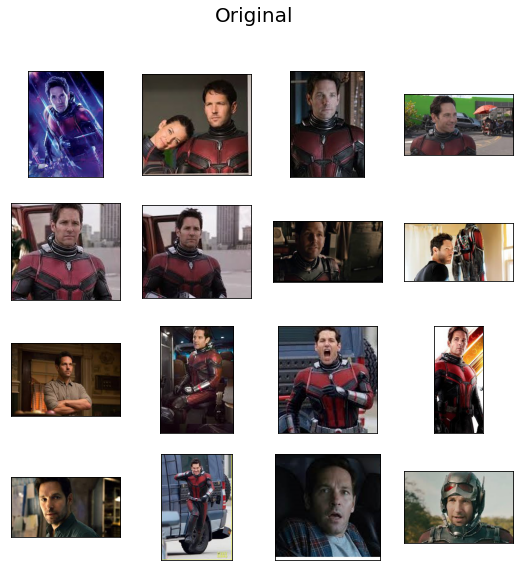

In [8]:
plt.figure(figsize=(9,9))
i = 0
for img in orig[0:16]:
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    i += 1
plt.suptitle("Original", fontsize=20)
plt.show()

In [52]:
# Load Image and Its Annotation  
for img_path in paths:
    img_name = img_path.split('\\')[-1].split('.')[0]
    anno_apth = f"data/{img_name}.txt"

    image = cv2.imread(img_path)
    #gt_boxes = file_lines_to_list(anno_apth)

    # Create Output Folder
    dir_path = f"AugmentedDataset"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    #gt_boxes = list(image.shape[:2]) Este lo añadí yo
    
    # Cutout
    #cutout = cutout(image, gt_boxes, amount=0.5)
    #gt_boxes=cv2.imwrite(f"{dir_path}/{img_name}_cutout.jpg", cutout)

    # ColorJitter
    b_img = colorjitter(image, cj_type="b")
    s_img = colorjitter(image, cj_type="s")
    c_img = colorjitter(image, cj_type="c")
    cv2.imwrite(f"{dir_path}/{img_name}_brightness.jpg", b_img)
    cv2.imwrite(f"{dir_path}/{img_name}_saturation.jpg", s_img)
    cv2.imwrite(f"{dir_path}/{img_name}_contrast.jpg", c_img)

    # Adding Noise
    gaussn_img = noisy(image, noise_type="gauss")
    sp_img = noisy(image, noise_type="sp")
    cv2.imwrite(f"{dir_path}/{img_name}_gaussnoise.jpg", gaussn_img)
    cv2.imwrite(f"{dir_path}/{img_name}_spnoise.jpg", sp_img)

    # Filtering
    blur_img = filters(image, f_type = "blur")
    gaussf_img = filters(image, f_type = "gaussian")
    median_img = filters(image, f_type = "median")
    cv2.imwrite(f"{dir_path}/{img_name}_blur.jpg", blur_img)
    cv2.imwrite(f"{dir_path}/{img_name}_gaussblur.jpg", gaussf_img)
    cv2.imwrite(f"{dir_path}/{img_name}_median.jpg", median_img)

    # Random Crop
    #rancrop, new_boxes = randomcrop(image, gt_boxes, scale=0.5)
    #cv2.imwrite(f"{dir_path}/{img_name}_rancrop.jpg", rancrop)
    #filepath = f"{dir_path}/{img_name}_rancrop.txt"
    #write_anno_to_txt(new_boxes, filepath)

    print("Generating Done!")

Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!


KeyboardInterrupt: 

Lo siguiente es otro ejemplo de transformación que se puede hacer en una sola linea, so supongo es hacerle una función para que guarde las pics con diferentes funciones de cv2

In [24]:
flip = [cv2.flip(img, np.random.choice([0, 1, -1])) if np.random.choice([0, 1]) else img for img in orig]

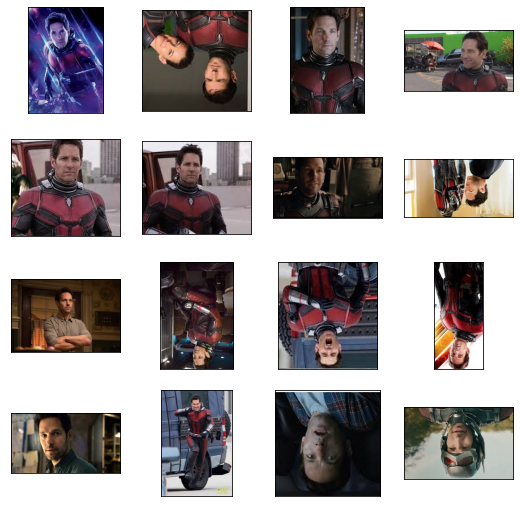

In [25]:
plt.figure(figsize=(9,9))
i = 0
for img in flip[0:16]:
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    i += 1
plt.show()